In [1]:
import torch
from torch import nn
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

import numpy as np

import matplotlib.pyplot as plt


In [2]:
# downloading the resources

train_data = datasets.MNIST(root="data",
                            train=True,
                            transform=ToTensor(),
                            target_transform=None,
                            download=True)

test_data = datasets.MNIST(root="data",
                           train=False,
                           transform=ToTensor(),
                           target_transform=None,
                           download=True)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:03<00:00, 2584622.56it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 479115.36it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4396312.15it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 5175367.77it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [3]:
# converting the data into batches
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False)

In [4]:
len(train_dataloader), len(test_dataloader)

(1875, 313)

In [5]:
class_names = train_data.classes
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [6]:
class_idx = train_data.class_to_idx
class_idx

{'0 - zero': 0,
 '1 - one': 1,
 '2 - two': 2,
 '3 - three': 3,
 '4 - four': 4,
 '5 - five': 5,
 '6 - six': 6,
 '7 - seven': 7,
 '8 - eight': 8,
 '9 - nine': 9}

## data visualization

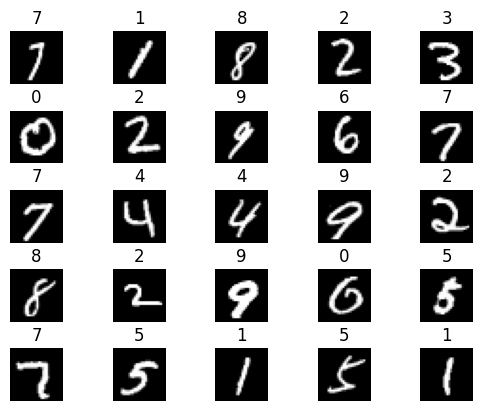

In [7]:
for i in range(25):
  image, label = train_data[np.random.randint(0,len(train_data))]
  plt.subplot(5,5,i+1)
  plt.imshow(image.squeeze(),cmap="gray")
  plt.title(label)
  plt.axis(False)

plt.subplots_adjust(hspace=0.5)  # Adjust hspace as needed, e.g., 0.5
plt.show()

## creating a model

In [8]:
# creating device agnostice code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [10]:
# creating a class for our model

class NumberClassification(nn.Module):
  def __init__(self, input_shape:int, hidden_units:int, output_shape:int):
    super().__init__()

    self.conv_block1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.conv_block2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
        )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*7*7,
                  out_features=output_shape)
    )

  def forward(self, x:torch.Tensor):
    x = self.conv_block1(x)
    x = self.conv_block2(x)
    x = self.classifier(x)
    return x

In [11]:
# initializing our model

# here the input_shape=1 because there is only one color channel here, ie: grayscale

model = NumberClassification(input_shape=1,
                             hidden_units=10,
                             output_shape=len(class_names)).to(device)

In [12]:
# creating loss and optimizer function

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(),
                            lr=0.1)

In [13]:
# importing helper functions
import requests
from os import path

if path.exists("helper_functions.py"):
  print("helper function exists")

else:
  req = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py","wb") as f:
    f.write(req.content)


## writing training and testing loop

In [20]:
from helper_functions import accuracy_fn
from tqdm.auto import tqdm
torch.manual_seed(42)

epochs = 3

for epoch in tqdm(range(epochs)):
  train_loss = 0
  accuracy = 0
  for batch, (X, y) in enumerate(train_dataloader):
    X, y = X.to(device), y.to(device)

    model.train()

    loss_logit = model(X)
    loss = loss_fn(loss_logit, y)
    train_loss += loss.item()
    accuracy += accuracy_fn(y_true=y,
                            y_pred=loss_logit.argmax(dim=1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print(f"Epoch: {epoch}")

  print(f" Train Loss: {train_loss/len(train_dataloader):.5f}, Train Accuracy: {accuracy/len(train_dataloader):.5f}")

  test_loss = 0
  test_accuracy = 0
  for X,y in test_dataloader:
    X, y = X.to(device), y.to(device)

    model.eval()
    with torch.inference_mode():
      test_logit = model(X)
      test_pred_labels = test_logit.argmax(dim=1)

      test_loss += loss_fn(test_logit, y)
      test_accuracy += accuracy_fn(y_true=y,
                                   y_pred=test_pred_labels)
  print(f" Test Loss: {test_loss/len(test_dataloader):.5f}, Test Accuracy: {test_accuracy/len(test_dataloader):.5f}")



  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
 Train Loss: 0.05043, Train Accuracy: 98.43333
 Test Loss: 0.05010, Test Accuracy: 98.43251
Epoch: 1
 Train Loss: 0.04377, Train Accuracy: 98.66667
 Test Loss: 0.04036, Test Accuracy: 98.66214
Epoch: 2
 Train Loss: 0.04037, Train Accuracy: 98.71333
 Test Loss: 0.05500, Test Accuracy: 98.31270


In [21]:
def eval_model(model: torch.nn.Module,
           data_loader: torch.utils.data.DataLoader,
           loss_fn: torch.nn.Module,
           accuracy_fn):
  total_loss, total_accuracy =0,0
  y_preds = []
  model.eval()
  with torch.inference_mode():
    for X,y in data_loader:
      X, y = X.to(device), y.to(device)
      y_logits = model(X)
      loss = loss_fn(y_logits, y)
      total_loss += loss.item()
      total_accuracy += accuracy_fn(y_true=y,
                                    y_pred=y_logits.argmax(dim=1))

      y_preds.append(y_logits.argmax(dim=1).cpu())

    return {
        "model_name": model.__class__.__name__,
        "model_loss": total_loss/len(data_loader),
        "model_accuracy": total_accuracy/len(data_loader)
    },y_preds

In [22]:
evaluation,y_preds = eval_model(model=model, data_loader=test_dataloader,loss_fn=loss_fn,accuracy_fn=accuracy_fn)
evaluation

{'model_name': 'NumberClassification',
 'model_loss': 0.054998904566470046,
 'model_accuracy': 98.31269968051119}

## visualizing the evaluation

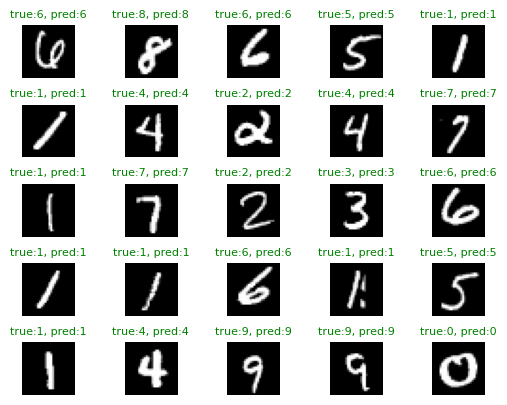

In [23]:
for i in range(25):
  image, label = test_data[np.random.randint(0,len(test_data))]

  # prediction
  y_logits = model(image.unsqueeze(dim=0).to(device))
  y_pred = class_idx[class_names[y_logits.argmax(dim=1).item()]]

  # plotting
  color = "green" if y_pred == label else "red"

  plt.subplot(5,5,i+1)
  plt.imshow(image.squeeze(),cmap="gray")
  plt.title(f"true:{label}, pred:{y_pred}", fontsize=8, color=color)
  plt.axis(False)

plt.subplots_adjust(hspace=0.5)  # Adjust hspace as needed, e.g., 0.5
plt.show()

##

In [27]:
try:
    import torchmetrics
    print("torchmetrics is already installed.")
except ImportError:
    import pip
    pip.main(['install', 'torchmetrics'])
    print("torchmetrics has been installed.")


torchmetrics is already installed.


In [25]:
y_preds = torch.cat(y_preds)
y_truth = test_data.targets


NumExpr defaulting to 2 threads.

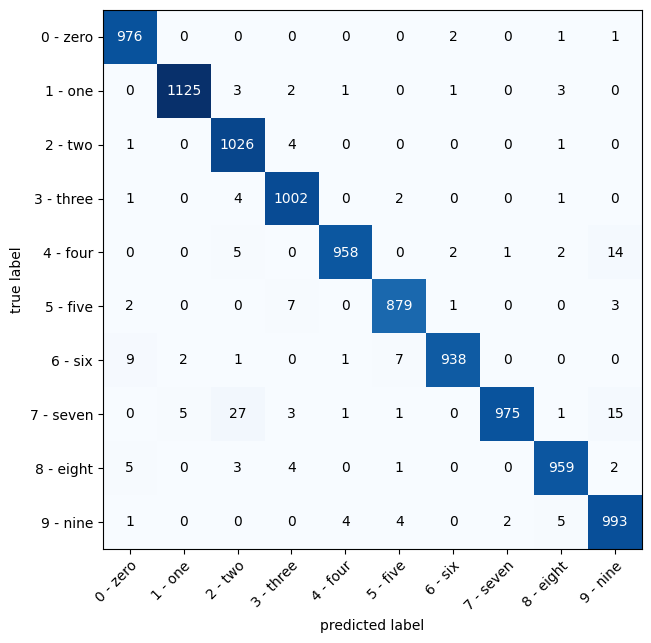

In [26]:
from torchmetrics.classification import MulticlassConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

metric = MulticlassConfusionMatrix(num_classes=len(class_names))
conf_mat = metric(y_preds, y_truth)

fig, ax = plot_confusion_matrix(
    conf_mat = conf_mat.numpy(),
    class_names = class_names,
    figsize = (10,7)
)